In [1]:
import os
import pandas as pd
import torch
import torchaudio
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

In [2]:
class TextTransform:
    """Maps characters to integers and vice versa."""
    def __init__(self):
        char_map_str = """
        ' 0
        <SPACE> 1
        ا 2
        ب 3
        ت 4
        ث 5
        ج 6
        ح 7
        خ 8
        د 9
        ذ 10
        ر 11
        ز 12
        س 13
        ش 14
        ص 15
        ض 16
        ط 17
        ظ 18
        ع 19
        غ 20
        ف 21
        ق 22
        ك 23
        ل 24
        م 25
        ن 26
        ه 27
        و 28
        ي 29
        ء 30
        آ 31
        أ 32
        ؤ 33
        إ 34
        ئ 35
        ى 36
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '  # Map <SPACE> to space character

    def text_to_int(self, text):
        """Converts text to an integer sequence using a character map."""
        int_sequence = []
        for c in text:
            if c == ' ':
                int_sequence.append(self.char_map['<SPACE>'])
            elif c in self.char_map:
                int_sequence.append(self.char_map[c])
            else:
                # Handle unknown characters (optional)
                int_sequence.append(0)  # Or another token for unknown characters
        return int_sequence

    def int_to_text(self, labels):
        """Converts integer labels to a text sequence using a character map."""
        return ''.join([self.index_map[i] for i in labels]).replace('<SPACE>', ' ')

In [3]:

# Example CSV path (replace with your CSV path)
csv_path = "./data/train.csv"

# Load CSV containing audio file names and transcripts
df = pd.read_csv(csv_path)

# List of audio file names and transcripts
audio_files = df['audio'].tolist()[:10]  # Limit to first 10 samples
transcripts = df['transcript'].tolist()[:10]  # Limit to first 10 samples

# Create an instance of TextTransform
text_transform = TextTransform()

# Process each transcript
for audio_file, transcript in zip(audio_files, transcripts):
    # Convert transcript to numerical representation (character indices)
    numerical_transcript = text_transform.text_to_int(transcript)
    
    # Convert numerical representation back to text for verification
    reconstructed_transcript = text_transform.int_to_text(numerical_transcript)
    
    # Print original and reconstructed transcripts for verification
    print(f"Original Transcript: {transcript}")
    print(f"Numerical Representation: {numerical_transcript}")
    print(f"Reconstructed Transcript: {reconstructed_transcript}")
    print("=" * 50)

Original Transcript: على إنها عار في الوقت اللي كانت بتتعامل مع أخويا الولد الوحيد معامله خاصه
Numerical Representation: [19, 24, 36, 1, 34, 26, 27, 2, 1, 19, 2, 11, 1, 21, 29, 1, 2, 24, 28, 22, 4, 1, 2, 24, 24, 29, 1, 23, 2, 26, 4, 1, 3, 4, 4, 19, 2, 25, 24, 1, 25, 19, 1, 32, 8, 28, 29, 2, 1, 2, 24, 28, 24, 9, 1, 2, 24, 28, 7, 29, 9, 1, 25, 19, 2, 25, 24, 27, 1, 8, 2, 15, 27]
Reconstructed Transcript: على إنها عار في الوقت اللي كانت بتتعامل مع أخويا الولد الوحيد معامله خاصه
Original Transcript: فأكيد ربنا عوضهم خير هو الراجل بيبقى ليه إختيارات معينه إم وشايف إن دول الأنسب لمنتخب مصر في الفتره
Numerical Representation: [21, 32, 23, 29, 9, 1, 11, 3, 26, 2, 1, 19, 28, 16, 27, 25, 1, 8, 29, 11, 1, 27, 28, 1, 2, 24, 11, 2, 6, 24, 1, 3, 29, 3, 22, 36, 1, 24, 29, 27, 1, 34, 8, 4, 29, 2, 11, 2, 4, 1, 25, 19, 29, 26, 27, 1, 34, 25, 1, 28, 14, 2, 29, 21, 1, 34, 26, 1, 9, 28, 24, 1, 2, 24, 32, 26, 13, 3, 1, 24, 25, 26, 4, 8, 3, 1, 25, 15, 11, 1, 21, 29, 1, 2, 24, 21, 4, 11, 27]
Reconstructed Tra

--------------------------

In [17]:
import os
import pandas as pd
import torchaudio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Function to load and process audio
def load_and_process_audio(audio_file_path):
    waveform, sample_rate = torchaudio.load(audio_file_path)
    return waveform, sample_rate

# Set the configuration for MFCC computation directly
sampling_rate = 16000
n_mfcc = 32
n_mels = 64

# Prepare the audio transformer for MFCC
audio_transformer_mfcc = torchaudio.transforms.MFCC(
    sample_rate=sampling_rate, 
    n_mfcc=n_mfcc,
    melkwargs={'n_fft': 300, 'hop_length': 120}
)

# Example CSV path (replace with your CSV path)
csv_path = "./data/train.csv"

# Directory containing audio files
audio_dir = "./data/sample/"

# Load CSV containing audio file names
df = pd.read_csv(csv_path)

# List of audio file names
audio_files = df['audio'].tolist()

# Prepare data for processing
data = []
for audio_file in audio_files:
    audio_file_path = os.path.join(audio_dir, f"{audio_file}.wav")
    waveform, sample_rate = load_and_process_audio(audio_file_path)
    data.append((waveform, sample_rate, audio_file))

# Process data and gather MFCC features
mfcc_features = []
for waveform, _, _ in data:
    mfcc = audio_transformer_mfcc(waveform).squeeze(0).transpose(0, 1)
    mfcc_features.append(mfcc)

/home/mohamed/.local/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (151) may be set too low.
  warnings.warn(


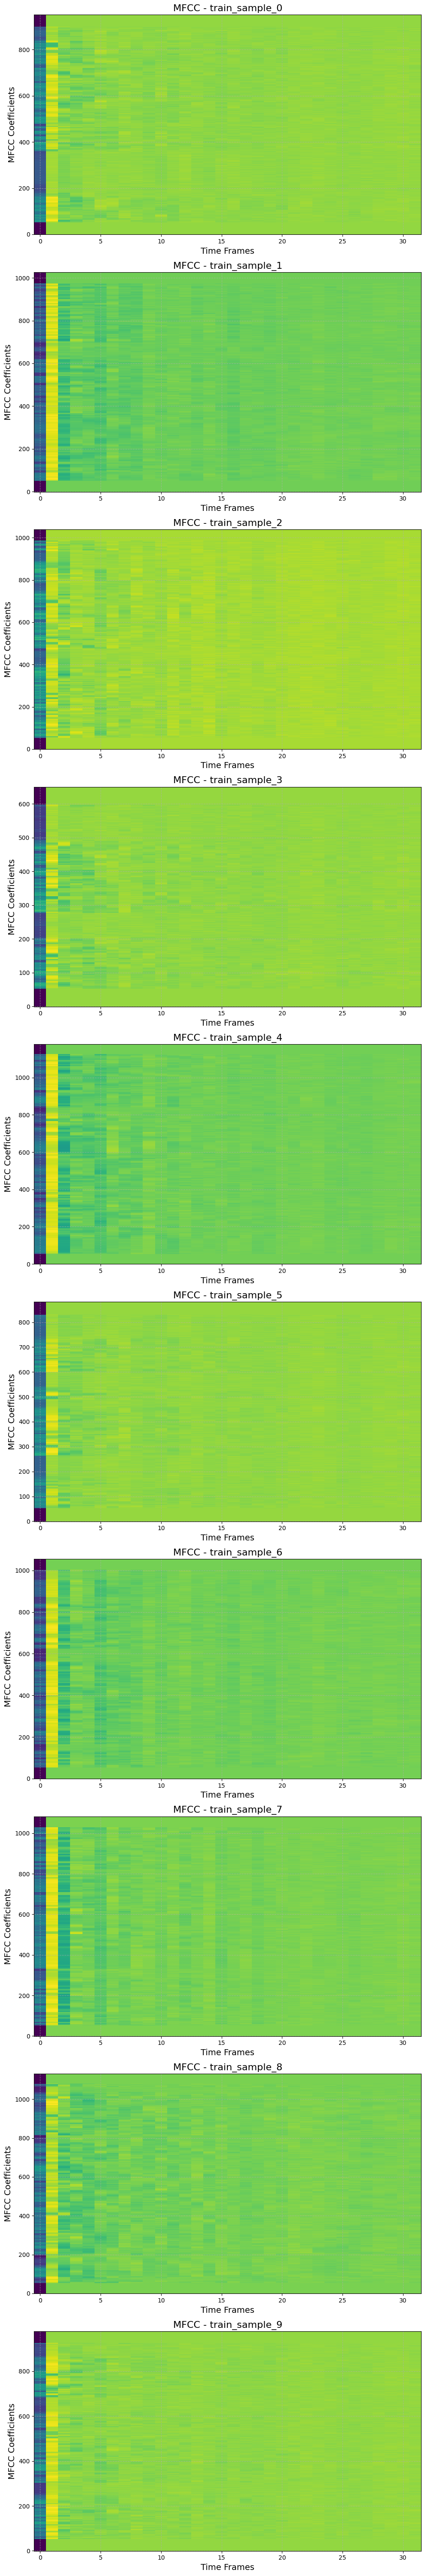

In [18]:
# Plotting a sample of MFCC spectrograms
num_samples = 10
fig, axes = plt.subplots(num_samples, 1, figsize=(10, 6 * num_samples))

for i in range(num_samples):
    mfcc = mfcc_features[i]

    ax = axes[i] if num_samples > 1 else axes
    ax.imshow(mfcc, cmap='viridis', aspect='auto',
              origin='lower', interpolation='nearest')
    ax.set_title(f'MFCC - {audio_files[i]}', fontsize=16)
    ax.set_xlabel('Time Frames', fontsize=14)
    ax.set_ylabel('MFCC Coefficients', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [42]:
len(mfcc_features)

100

In [44]:
# Print shape for each sample in padded_mfcc_features
for i in range(len(mfcc_features)):
    print(f"Sample {i + 1} shape:", mfcc_features[i].shape)

Sample 1 shape: torch.Size([951, 13])
Sample 2 shape: torch.Size([1027, 13])
Sample 3 shape: torch.Size([1039, 13])
Sample 4 shape: torch.Size([651, 13])
Sample 5 shape: torch.Size([1179, 13])
Sample 6 shape: torch.Size([883, 13])
Sample 7 shape: torch.Size([1055, 13])
Sample 8 shape: torch.Size([1083, 13])
Sample 9 shape: torch.Size([1131, 13])
Sample 10 shape: torch.Size([979, 13])
Sample 11 shape: torch.Size([899, 13])
Sample 12 shape: torch.Size([1015, 13])
Sample 13 shape: torch.Size([1031, 13])
Sample 14 shape: torch.Size([903, 13])
Sample 15 shape: torch.Size([739, 13])
Sample 16 shape: torch.Size([987, 13])
Sample 17 shape: torch.Size([867, 13])
Sample 18 shape: torch.Size([1111, 13])
Sample 19 shape: torch.Size([755, 13])
Sample 20 shape: torch.Size([1087, 13])
Sample 21 shape: torch.Size([895, 13])
Sample 22 shape: torch.Size([903, 13])
Sample 23 shape: torch.Size([1147, 13])
Sample 24 shape: torch.Size([839, 13])
Sample 25 shape: torch.Size([1155, 13])
Sample 26 shape: torch

In [45]:
# Pad sequences for batch processing
padded_mfcc_features = nn.utils.rnn.pad_sequence(mfcc_features, batch_first=True)

# Convert to NumPy for plotting
padded_mfcc_np = padded_mfcc_features.numpy()

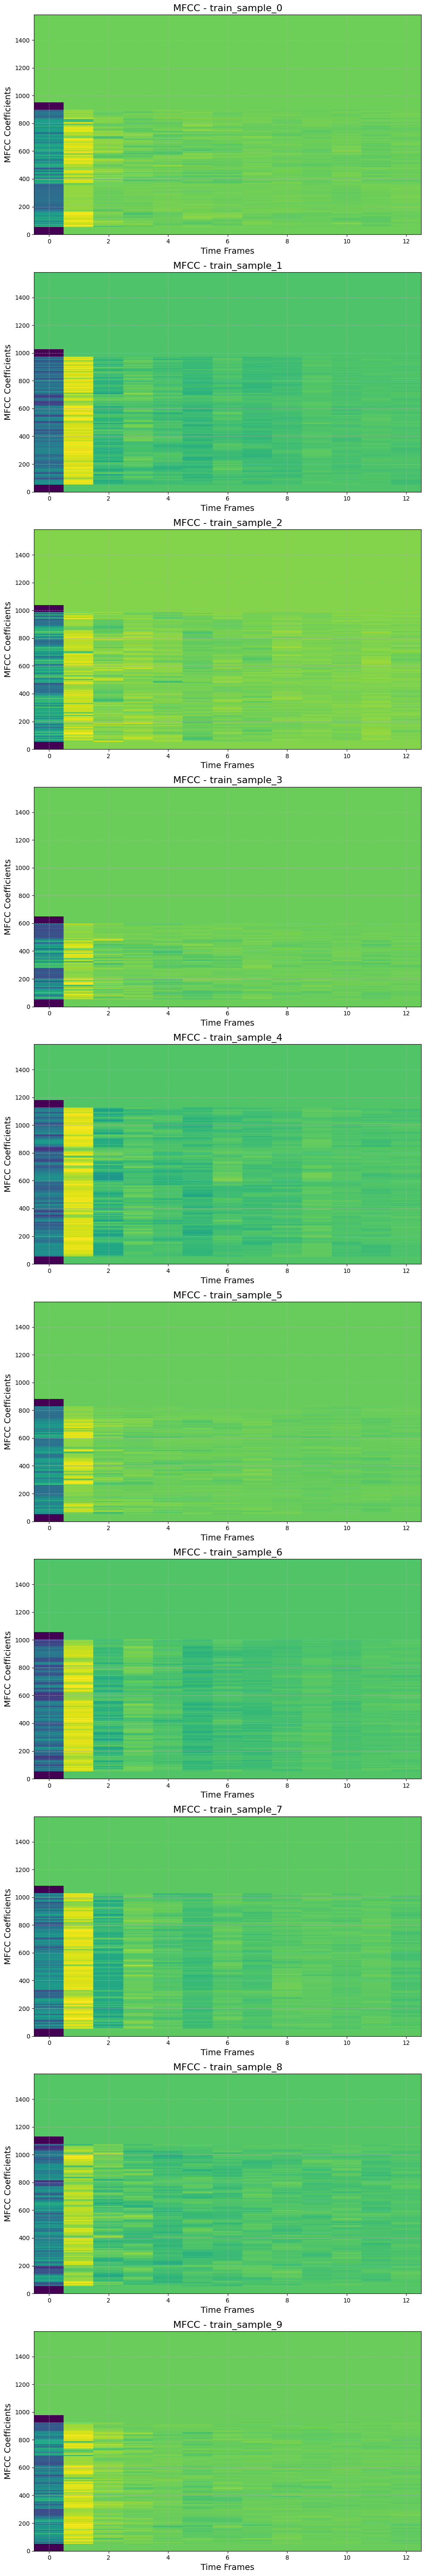

In [46]:
# Plotting a sample of MFCC spectrograms
num_samples = 10
fig, axes = plt.subplots(num_samples, 1, figsize=(10, 6 * num_samples))

for i in range(num_samples):
    mfcc = padded_mfcc_np[i]

    ax = axes[i] if num_samples > 1 else axes
    ax.imshow(mfcc, cmap='viridis', aspect='auto',
              origin='lower', interpolation='nearest')
    ax.set_title(f'MFCC - {audio_files[i]}', fontsize=16)
    ax.set_xlabel('Time Frames', fontsize=14)
    ax.set_ylabel('MFCC Coefficients', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [47]:
len(padded_mfcc_features)

100

In [48]:
# Print shape for each sample in padded_mfcc_features
for i in range(len(padded_mfcc_features)):
    print(f"Sample {i + 1} shape:", padded_mfcc_features[i].shape)

Sample 1 shape: torch.Size([1583, 13])
Sample 2 shape: torch.Size([1583, 13])
Sample 3 shape: torch.Size([1583, 13])
Sample 4 shape: torch.Size([1583, 13])
Sample 5 shape: torch.Size([1583, 13])
Sample 6 shape: torch.Size([1583, 13])
Sample 7 shape: torch.Size([1583, 13])
Sample 8 shape: torch.Size([1583, 13])
Sample 9 shape: torch.Size([1583, 13])
Sample 10 shape: torch.Size([1583, 13])
Sample 11 shape: torch.Size([1583, 13])
Sample 12 shape: torch.Size([1583, 13])
Sample 13 shape: torch.Size([1583, 13])
Sample 14 shape: torch.Size([1583, 13])
Sample 15 shape: torch.Size([1583, 13])
Sample 16 shape: torch.Size([1583, 13])
Sample 17 shape: torch.Size([1583, 13])
Sample 18 shape: torch.Size([1583, 13])
Sample 19 shape: torch.Size([1583, 13])
Sample 20 shape: torch.Size([1583, 13])
Sample 21 shape: torch.Size([1583, 13])
Sample 22 shape: torch.Size([1583, 13])
Sample 23 shape: torch.Size([1583, 13])
Sample 24 shape: torch.Size([1583, 13])
Sample 25 shape: torch.Size([1583, 13])
Sample 26

In [49]:

# def data_preprocessing(data, data_type='train'):
#     spectrograms = []
#     labels = []
#     input_lengths = []
#     label_lengths = []
#     for (waveform, _, utterance, _, _, _) in data:
#         if data_type == 'train':
#             spec = train_audio_transformer(waveform).squeeze(0).transpose(0,1)
#         elif data_type == 'valid':
#             spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
#         else:
#             raise Exception('data_type should be train or valid')
#         spectrograms.append(spec)
#             label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
#             labels.append(label)
#             input_lengths.append(spec.shape[0]//2)
#             label_lengths.append(len(label))

#     spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
#     labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

#     return spectrograms, labels, input_lengths, label_lengths